TAREA: La tarea consiste en extraer características (geométricas y/o visuales) de las tres imágenes completas de partida, y *aprender* patrones que permitan identificar las partículas en nuevas imágenes. Para ello se proporciona como imagen de test *MPs_test.jpg* y sus correpondientes anotaciones *MPs_test_bbs.csv* con la que deben obtener las métricas para su propuesta de clasificación de microplásticos, además de la matriz de confusión. La matriz de confusión permitirá mostrar para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente como perteneciente a una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

Contornos detectados: 54
Anotaciones en CSV: 97

=== COMPARACIÓN ===
Contorno 2: Posición (85, 1162) -> Real: FRA, Predicho: FRA
Contorno 3: Posición (248, 1150) -> Real: PEL, Predicho: PEL
Contorno 4: Posición (316, 1147) -> Real: PEL, Predicho: PEL
Contorno 5: Posición (209, 1103) -> Real: TAR, Predicho: TAR
Contorno 6: Posición (554, 1086) -> Real: PEL, Predicho: PEL
Contorno 7: Posición (21, 1086) -> Real: TAR, Predicho: TAR
Contorno 8: Posición (179, 1069) -> Real: PEL, Predicho: PEL
Contorno 9: Posición (595, 1065) -> Real: FRA, Predicho: FRA
Contorno 10: Posición (276, 1064) -> Real: FRA, Predicho: FRA
Contorno 12: Posición (269, 1039) -> Real: FRA, Predicho: FRA
Contorno 13: Posición (280, 1024) -> Real: PEL, Predicho: PEL
Contorno 14: Posición (529, 1022) -> Real: TAR, Predicho: TAR
Contorno 15: Posición (36, 1017) -> Real: FRA, Predicho: FRA
Contorno 16: Posición (150, 1014) -> Real: FRA, Predicho: FRA
Contorno 18: Posición (281, 993) -> Real: PEL, Predicho: PEL
Contorno 20: 

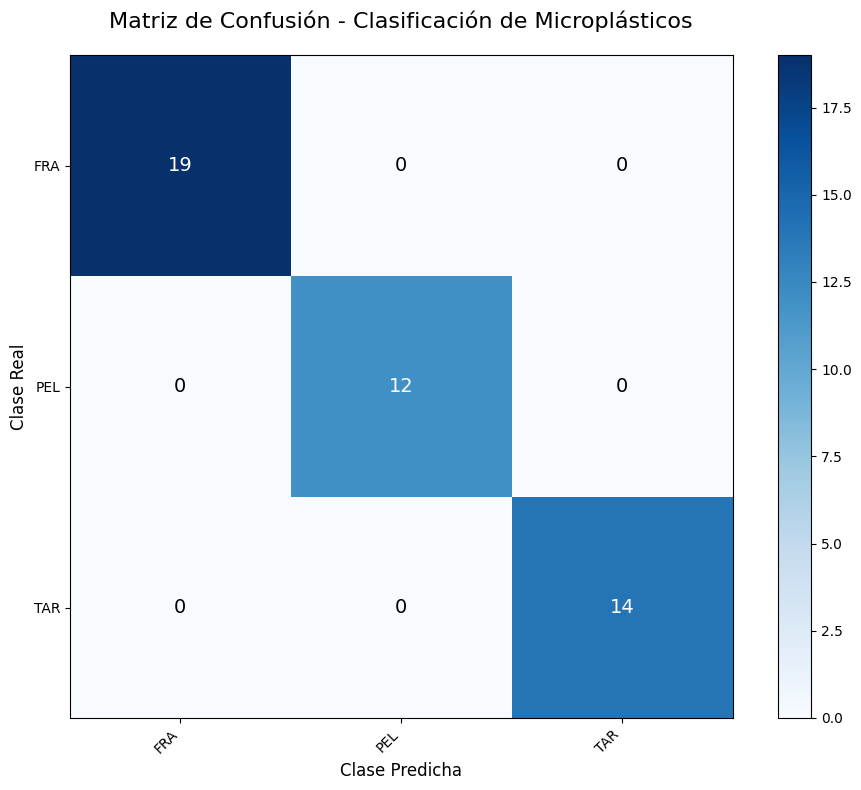

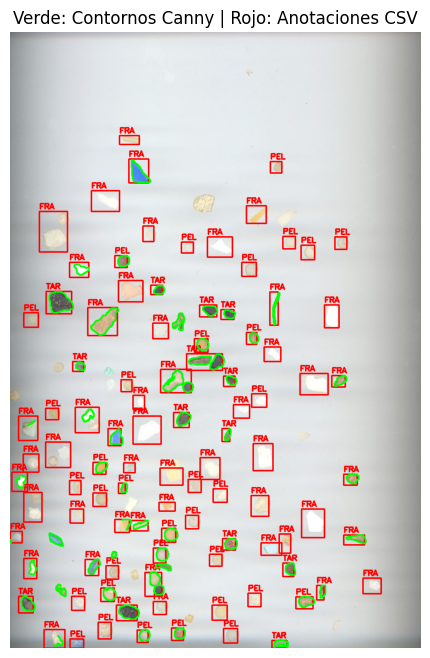

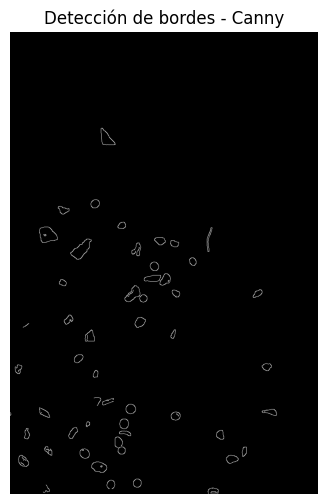

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import csv

# Cargar imagen
img = cv2.imread('MPs_test.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Aplicar blur
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Aplicar Canny
edges = cv2.Canny(blurred, 50, 150)

# Encontrar contornos
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

print(f"Contornos detectados: {len(contours)}")

# Cargar anotaciones del CSV (sin encabezados)
annotations = []
with open('MPs_test_bbs.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        clase = row[0]
        x1 = float(row[1])
        y1 = float(row[2])
        x2 = float(row[3])
        y2 = float(row[4])
        
        # Calcular ancho y alto
        width = x2 - x1
        height = y2 - y1
        
        annotations.append({
            'x': x1,
            'y': y1,
            'width': width,
            'height': height,
            'class': clase
        })

print(f"Anotaciones en CSV: {len(annotations)}")

# Comparar contornos con anotaciones
print("\n=== COMPARACIÓN ===")
matched_count = 0
y_true = []  # Clases reales
y_pred = []  # Clases predichas

for i, contour in enumerate(contours):
    # Filtrar contornos pequeños
    if cv2.contourArea(contour) < 10:
        continue
    
    # Obtener bounding box del contorno
    x, y, w, h = cv2.boundingRect(contour)
    cx = x + w // 2  # Centro X
    cy = y + h // 2  # Centro Y
    
    # Buscar anotación más cercana
    min_distance = float('inf')
    matched_class = None
    matched_ann = None
    
    for ann in annotations:
        # Centro de la anotación
        ann_cx = ann['x'] + ann['width'] / 2
        ann_cy = ann['y'] + ann['height'] / 2
        
        # Distancia entre centros
        distance = np.sqrt((cx - ann_cx)**2 + (cy - ann_cy)**2)
        
        # Si está cerca (tolerancia = 30 píxeles)
        if distance < 30 and distance < min_distance:
            min_distance = distance
            matched_class = ann['class']
            matched_ann = ann
    
    # Si encontró match
    if matched_class:
        matched_count += 1
        # Aquí deberías tener tu clasificador que predice la clase
        # Por ahora, simulamos predicción (puedes reemplazar esto con tu modelo)
        predicted_class = matched_class  # Simulación - reemplaza con tu predicción real
        
        y_true.append(matched_class)
        y_pred.append(predicted_class)
        
        print(f"Contorno {i}: Posición ({x}, {y}) -> Real: {matched_class}, Predicho: {predicted_class}")

print(f"\nTotal emparejados: {matched_count}/{len(annotations)}")
print(f"Porcentaje de acierto: {matched_count / len(annotations) * 100:.2f}%")

# Obtener clases únicas
classes = sorted(list(set(y_true)))
print(f"\nClases encontradas: {classes}")

# Crear matriz de confusión
n_classes = len(classes)
confusion_matrix = np.zeros((n_classes, n_classes), dtype=int)

# Mapeo de clase a índice
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

# Llenar matriz de confusión
for true, pred in zip(y_true, y_pred):
    true_idx = class_to_idx[true]
    pred_idx = class_to_idx[pred]
    confusion_matrix[true_idx, pred_idx] += 1

# Mostrar matriz de confusión
print("\n=== MATRIZ DE CONFUSIÓN ===")
print(f"{'':10}", end='')
for cls in classes:
    print(f"{cls:>10}", end='')
print()

for i, cls in enumerate(classes):
    print(f"{cls:10}", end='')
    for j in range(n_classes):
        print(f"{confusion_matrix[i, j]:>10}", end='')
    print()

# Calcular métricas por clase
print("\n=== MÉTRICAS POR CLASE ===")
print(f"{'Clase':<10} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-" * 60)

for i, cls in enumerate(classes):
    tp = confusion_matrix[i, i]
    fp = np.sum(confusion_matrix[:, i]) - tp
    fn = np.sum(confusion_matrix[i, :]) - tp
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    support = tp + fn
    
    print(f"{cls:<10} {precision:<12.3f} {recall:<12.3f} {f1:<12.3f} {support:<10}")

# Accuracy global
total_correct = np.trace(confusion_matrix)
total_samples = np.sum(confusion_matrix)
accuracy = total_correct / total_samples if total_samples > 0 else 0
print("-" * 60)
print(f"Accuracy Global: {accuracy:.3f}")

# Visualizar matriz de confusión
plt.figure(figsize=(10, 8))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión - Clasificación de Microplásticos', fontsize=16, pad=20)
plt.colorbar()

tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, classes, rotation=45, ha='right')
plt.yticks(tick_marks, classes)

# Añadir valores numéricos
thresh = confusion_matrix.max() / 2.
for i in range(n_classes):
    for j in range(n_classes):
        plt.text(j, i, format(confusion_matrix[i, j], 'd'),
                ha="center", va="center",
                color="white" if confusion_matrix[i, j] > thresh else "black",
                fontsize=14)

plt.ylabel('Clase Real', fontsize=12)
plt.xlabel('Clase Predicha', fontsize=12)
plt.tight_layout()
plt.savefig('matriz_confusion.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualizar resultados
img_result = img.copy()

# Dibujar anotaciones del CSV en rojo
for ann in annotations:
    x = int(ann['x'])
    y = int(ann['y'])
    w = int(ann['width'])
    h = int(ann['height'])
    cv2.rectangle(img_result, (x, y), (x + w, y + h), (0, 0, 255), 2)
    cv2.putText(img_result, ann['class'], (x, y - 5), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

# Dibujar contornos detectados en verde
cv2.drawContours(img_result, contours, -1, (0, 255, 0), 2)

# Mostrar imagen con resultados
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
plt.title('Verde: Contornos Canny | Rojo: Anotaciones CSV')
plt.axis('off')
plt.savefig('resultados.png', dpi=300, bbox_inches='tight')
plt.show()

# Mostrar Canny
plt.figure(figsize=(10, 6))
plt.imshow(edges, cmap='gray')
plt.title('Detección de bordes - Canny')
plt.axis('off')
plt.savefig('canny.png', dpi=300, bbox_inches='tight')
plt.show()

# PRUEBA 2

Dimensiones de imagen: (1186, 790, 3)
Imagen cargada correctamente
Segmentación completada
Contornos detectados (raw): 1234
Contornos filtrados: 154
Encabezados CSV: ['label', 'x_min', 'y_min', 'x_max', 'y_max']
Anotaciones en CSV: 97

=== EMPAREJAMIENTO ===
Total emparejados: 80/97
Recall: 82.47%

=== MATRIZ DE CONFUSIÓN ===
                 FRA       PEL       TAR
FRA               25        16         0
PEL                2        26         0
TAR                1        10         0

=== MÉTRICAS POR CLASE ===
Clase      Precision    Recall       F1-Score     Support   
------------------------------------------------------------
FRA        0.893        0.610        0.725        41        
PEL        0.500        0.929        0.650        28        
TAR        0.000        0.000        0.000        11        
------------------------------------------------------------
Accuracy Global: 0.637

=== ANÁLISIS DE ERRORES ===
TAR: 11 errores
  - Clasificados como PEL: 10
  - Clasificados

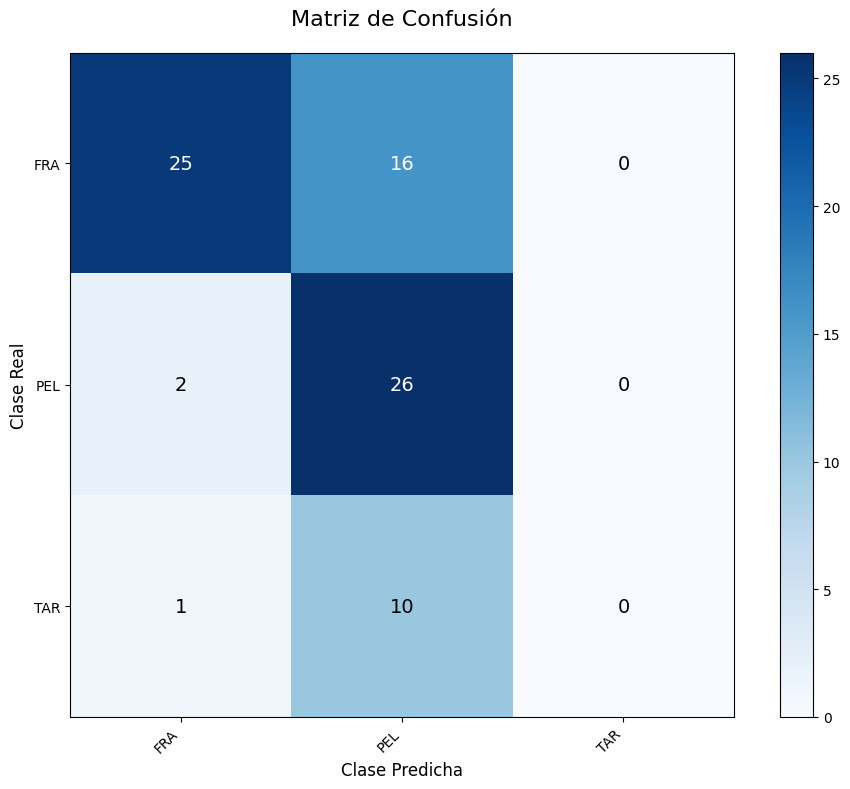


✓ Matriz de confusión guardada


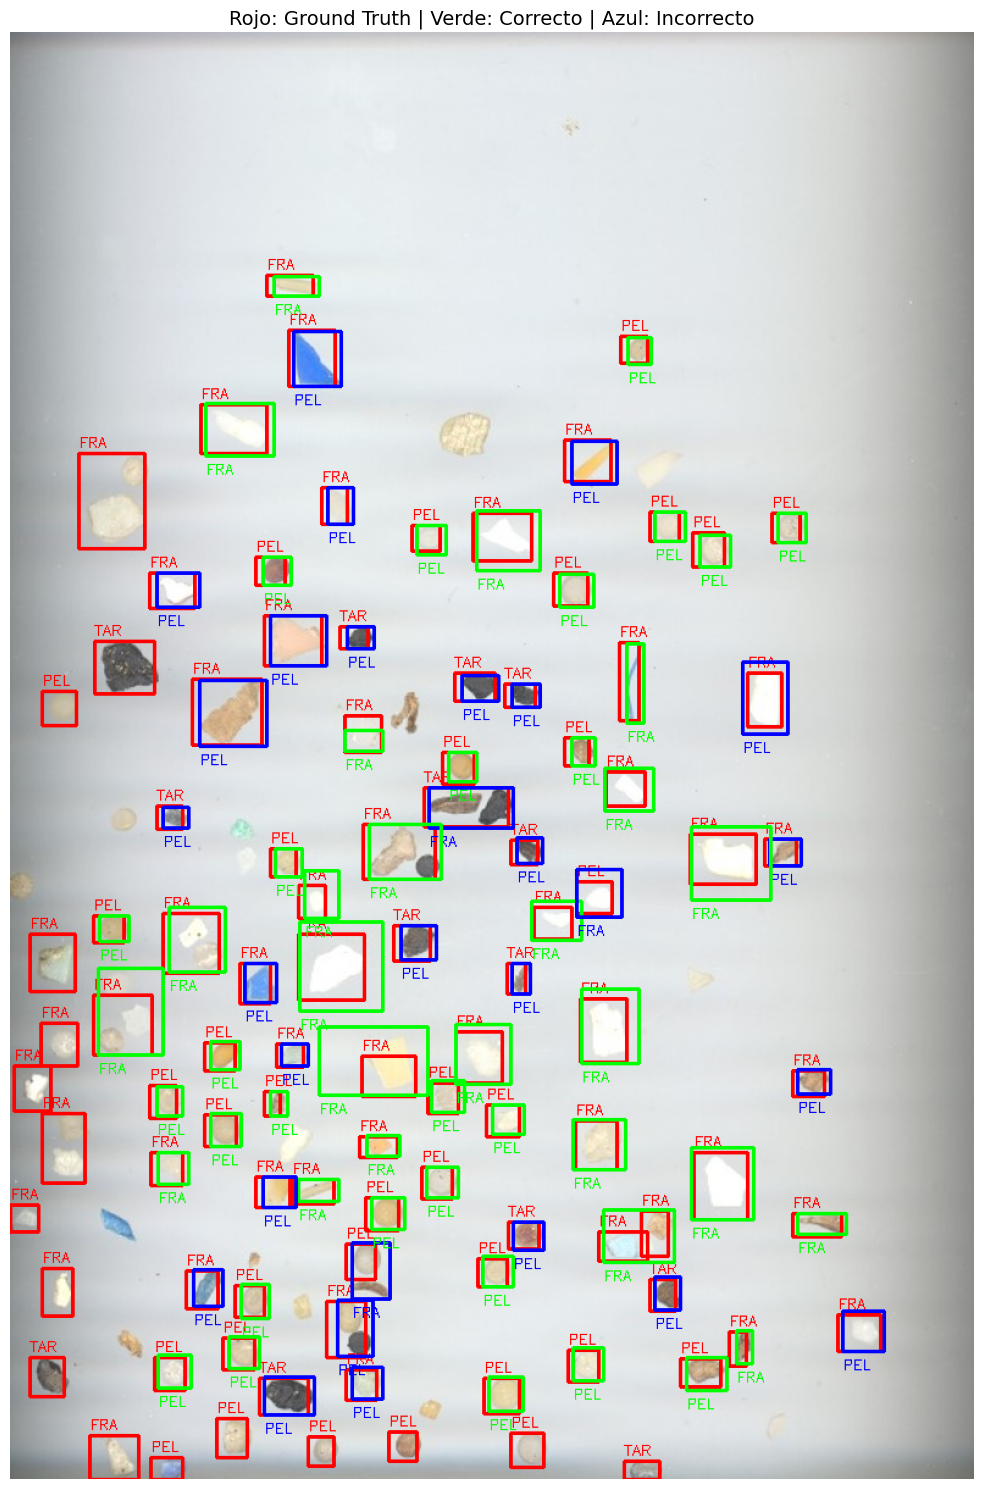

✓ Resultados visuales guardados


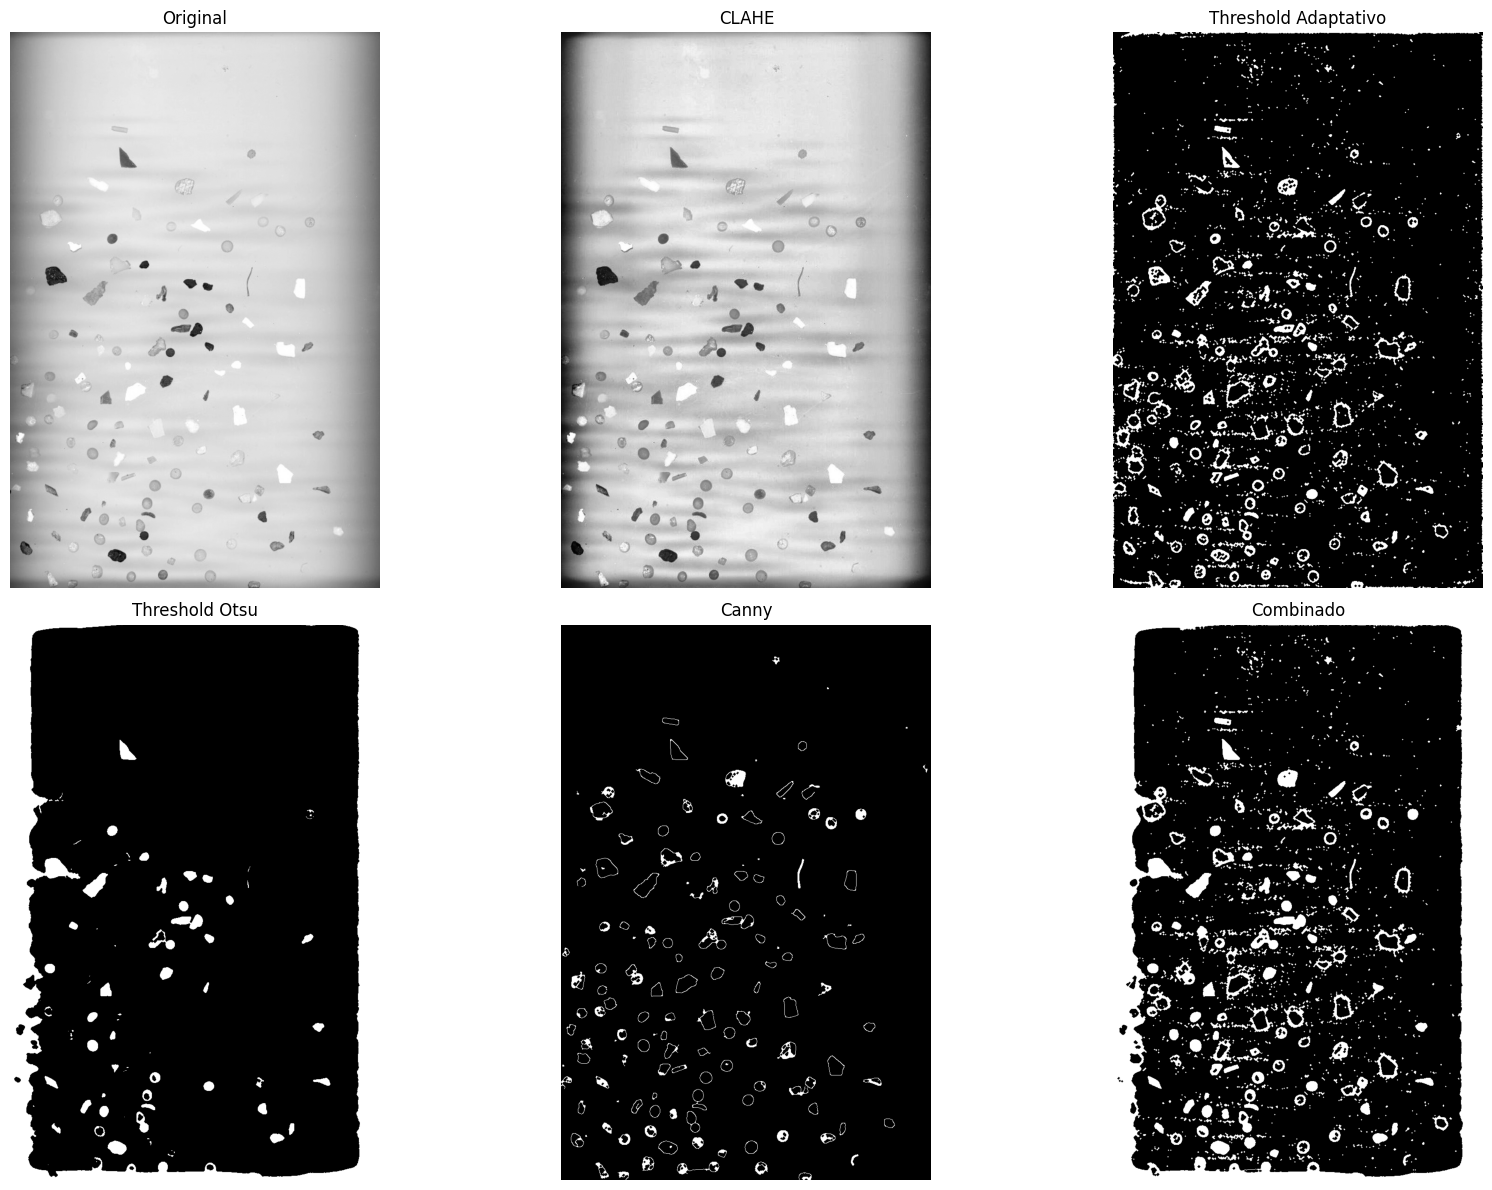

✓ Pasos de segmentación guardados
✓ Resultados guardados en 'resultados_clasificacion.csv'

=== PROCESO COMPLETADO ===


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import csv
from collections import defaultdict
import os

# ============================================
# FUNCIÓN DE IoU (Intersection over Union)
# ============================================

def calculate_iou(box1, box2):
    """
    Calcula IoU entre dos bounding boxes
    box = (x, y, width, height)
    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    # Coordenadas de intersección
    xi1 = max(x1, x2)
    yi1 = max(y1, y2)
    xi2 = min(x1 + w1, x2 + w2)
    yi2 = min(y1 + h1, y2 + h2)
    
    # Área de intersección
    inter_width = max(0, xi2 - xi1)
    inter_height = max(0, yi2 - yi1)
    inter_area = inter_width * inter_height
    
    # Áreas de cada box
    box1_area = w1 * h1
    box2_area = w2 * h2
    
    # Unión
    union_area = box1_area + box2_area - inter_area
    
    if union_area == 0:
        return 0
    
    iou = inter_area / union_area
    return iou

# ============================================
# FUNCIÓN PARA EXTRAER CARACTERÍSTICAS
# ============================================

def extract_features(contour):
    """
    Extrae características geométricas básicas
    """
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    x, y, w, h = cv2.boundingRect(contour)
    
    # Aspect ratio
    aspect_ratio = float(w) / h if h != 0 else 0
    
    # Compacidad
    compactness = (perimeter ** 2) / area if area > 0 else 0
    
    # Relación área/bbox
    bbox_area = w * h
    extent = area / bbox_area if bbox_area > 0 else 0
    
    # Solidez (convex hull)
    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)
    solidity = area / hull_area if hull_area > 0 else 0
    
    return {
        'area': area,
        'perimeter': perimeter,
        'aspect_ratio': aspect_ratio,
        'compactness': compactness,
        'extent': extent,
        'solidity': solidity,
        'width': w,
        'height': h
    }

# ============================================
# CLASIFICADOR HEURÍSTICO
# ============================================

def classify_particle(features):
    """
    Clasifica partícula basado en características geométricas
    Ajusta estos umbrales según tus resultados
    """
    ar = features['aspect_ratio']
    compactness = features['compactness']
    extent = features['extent']
    solidity = features['solidity']
    area = features['area']
    
    # FRA (Fragmentos): irregulares, compactos, solidez media-baja
    if solidity < 0.85 and compactness > 15:
        return 'FRA'
    
    # PEL (Pellets): circulares/cuadrados, compactos, alta solidez
    if 0.7 <= ar <= 1.3 and extent > 0.7 and solidity > 0.85:
        return 'PEL'
    
    # TAR (Alquitrán): formas muy irregulares, baja solidez
    if solidity < 0.75:
        return 'TAR'
    
    # FRA como default para formas angulares
    if ar > 1.5 or ar < 0.6:
        return 'FRA'
    
    # Default: PEL
    return 'PEL'

# ============================================
# VERIFICAR ARCHIVOS
# ============================================

if not os.path.exists('MPs_test.jpg'):
    print("ERROR: No se encontró 'MPs_test.jpg'")
    print("Archivos disponibles:", os.listdir('.'))
    exit()

if not os.path.exists('MPs_test_bbs.csv'):
    print("ERROR: No se encontró 'MPs_test_bbs.csv'")
    print("Archivos disponibles:", os.listdir('.'))
    exit()

# ============================================
# CARGAR Y PREPROCESAR IMAGEN
# ============================================

img = cv2.imread('MPs_test.jpg')
if img is None:
    print("Error: No se pudo cargar la imagen")
    exit()

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(f"Dimensiones de imagen: {img.shape}")
print(f"Imagen cargada correctamente")

# ============================================
# SEGMENTACIÓN - MÚLTIPLES MÉTODOS
# ============================================

# CLAHE para mejorar contraste
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
enhanced = clahe.apply(gray)

# Blur para reducir ruido
blurred = cv2.GaussianBlur(enhanced, (5, 5), 0)

# Método 1: Umbralización Adaptativa
thresh_adaptive = cv2.adaptiveThreshold(
    blurred, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV,
    11, 2
)

# Operaciones morfológicas
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
thresh_adaptive = cv2.morphologyEx(thresh_adaptive, cv2.MORPH_CLOSE, kernel, iterations=2)
thresh_adaptive = cv2.morphologyEx(thresh_adaptive, cv2.MORPH_OPEN, kernel, iterations=1)

# Método 2: Otsu
_, thresh_otsu = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
thresh_otsu = cv2.morphologyEx(thresh_otsu, cv2.MORPH_CLOSE, kernel, iterations=2)

# Método 3: Canny
edges = cv2.Canny(blurred, 30, 100)
edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=2)

# Combinar todos los métodos
combined = cv2.bitwise_or(thresh_adaptive, thresh_otsu)
combined = cv2.bitwise_or(combined, edges)
combined = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel, iterations=2)

print("Segmentación completada")

# ============================================
# ENCONTRAR CONTORNOS
# ============================================

contours, _ = cv2.findContours(combined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f"Contornos detectados (raw): {len(contours)}")

# Filtrar contornos por área
min_area = 30
max_area = 5000

filtered_contours = []
for cnt in contours:
    area = cv2.contourArea(cnt)
    if min_area < area < max_area:
        filtered_contours.append(cnt)

print(f"Contornos filtrados: {len(filtered_contours)}")

# ============================================
# CARGAR ANOTACIONES
# ============================================

annotations = []
try:
    with open('MPs_test_bbs.csv', 'r') as file:
        reader = csv.reader(file)
        header = next(reader)
        print(f"Encabezados CSV: {header}")
        
        for row in reader:
            clase = row[0]
            x1 = float(row[1])
            y1 = float(row[2])
            x2 = float(row[3])
            y2 = float(row[4])
            
            width = x2 - x1
            height = y2 - y1
            
            annotations.append({
                'x': x1,
                'y': y1,
                'width': width,
                'height': height,
                'class': clase,
                'matched': False
            })
    
    print(f"Anotaciones en CSV: {len(annotations)}")
    
except Exception as e:
    print(f"Error al leer CSV: {e}")
    exit()

# ============================================
# EMPAREJAR CONTORNOS CON ANOTACIONES
# ============================================

y_true = []
y_pred = []
matched_data = []

for ann in annotations:
    ann_box = (ann['x'], ann['y'], ann['width'], ann['height'])
    
    best_iou = 0
    best_contour = None
    best_contour_idx = -1
    
    for idx, contour in enumerate(filtered_contours):
        x, y, w, h = cv2.boundingRect(contour)
        contour_box = (x, y, w, h)
        
        iou = calculate_iou(ann_box, contour_box)
        
        if iou > best_iou:
            best_iou = iou
            best_contour = contour
            best_contour_idx = idx
    
    # Umbral de IoU más bajo para capturar más matches
    if best_iou > 0.2:
        features = extract_features(best_contour)
        predicted_class = classify_particle(features)
        
        y_true.append(ann['class'])
        y_pred.append(predicted_class)
        
        x, y, w, h = cv2.boundingRect(best_contour)
        matched_data.append({
            'contour': best_contour,
            'true_class': ann['class'],
            'pred_class': predicted_class,
            'bbox': (x, y, w, h),
            'iou': best_iou,
            'features': features
        })
        
        ann['matched'] = True

print(f"\n=== EMPAREJAMIENTO ===")
print(f"Total emparejados: {len(matched_data)}/{len(annotations)}")
if len(annotations) > 0:
    print(f"Recall: {len(matched_data) / len(annotations) * 100:.2f}%")

if len(y_true) == 0:
    print("\nADVERTENCIA: No se encontraron matches. Ajusta los parámetros de segmentación.")
    print("Intenta reducir min_area o ajustar los umbrales de Canny/threshold.")
    exit()

# ============================================
# MATRIZ DE CONFUSIÓN
# ============================================

classes = sorted(list(set(y_true)))
n_classes = len(classes)
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

confusion_matrix = np.zeros((n_classes, n_classes), dtype=int)

for true, pred in zip(y_true, y_pred):
    true_idx = class_to_idx[true]
    pred_idx = class_to_idx[pred]
    confusion_matrix[true_idx, pred_idx] += 1

print("\n=== MATRIZ DE CONFUSIÓN ===")
print(f"{'':10}", end='')
for cls in classes:
    print(f"{cls:>10}", end='')
print()

for i, cls in enumerate(classes):
    print(f"{cls:10}", end='')
    for j in range(n_classes):
        print(f"{confusion_matrix[i, j]:>10}", end='')
    print()

# ============================================
# MÉTRICAS
# ============================================

print("\n=== MÉTRICAS POR CLASE ===")
print(f"{'Clase':<10} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-" * 60)

for i, cls in enumerate(classes):
    tp = confusion_matrix[i, i]
    fp = np.sum(confusion_matrix[:, i]) - tp
    fn = np.sum(confusion_matrix[i, :]) - tp
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    support = tp + fn
    
    print(f"{cls:<10} {precision:<12.3f} {recall:<12.3f} {f1:<12.3f} {support:<10}")

total_correct = np.trace(confusion_matrix)
total_samples = np.sum(confusion_matrix)
accuracy = total_correct / total_samples if total_samples > 0 else 0

print("-" * 60)
print(f"Accuracy Global: {accuracy:.3f}")

# ============================================
# ANÁLISIS DE ERRORES
# ============================================

print("\n=== ANÁLISIS DE ERRORES ===")
errors_by_class = defaultdict(list)

for data in matched_data:
    if data['true_class'] != data['pred_class']:
        errors_by_class[data['true_class']].append(data['pred_class'])

for cls, errors in errors_by_class.items():
    if errors:
        print(f"{cls}: {len(errors)} errores")
        from collections import Counter
        counts = Counter(errors)
        for pred_cls, count in counts.items():
            print(f"  - Clasificados como {pred_cls}: {count}")

# ============================================
# VISUALIZACIÓN 1: MATRIZ DE CONFUSIÓN
# ============================================

plt.figure(figsize=(10, 8))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión', fontsize=16, pad=20)
plt.colorbar()

tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, classes, rotation=45, ha='right')
plt.yticks(tick_marks, classes)

thresh = confusion_matrix.max() / 2. if confusion_matrix.max() > 0 else 0.5
for i in range(n_classes):
    for j in range(n_classes):
        plt.text(j, i, format(confusion_matrix[i, j], 'd'),
                ha="center", va="center",
                color="white" if confusion_matrix[i, j] > thresh else "black",
                fontsize=14)

plt.ylabel('Clase Real', fontsize=12)
plt.xlabel('Clase Predicha', fontsize=12)
plt.tight_layout()
plt.savefig('matriz_confusion_mejorada.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Matriz de confusión guardada")

# ============================================
# VISUALIZACIÓN 2: RESULTADOS
# ============================================

img_result = img.copy()

# Anotaciones en rojo
for ann in annotations:
    x = int(ann['x'])
    y = int(ann['y'])
    w = int(ann['width'])
    h = int(ann['height'])
    cv2.rectangle(img_result, (x, y), (x + w, y + h), (0, 0, 255), 2)
    cv2.putText(img_result, ann['class'], (x, y - 5),
               cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)

# Predicciones: verde=correcto, azul=incorrecto
for data in matched_data:
    x, y, w, h = data['bbox']
    color = (0, 255, 0) if data['true_class'] == data['pred_class'] else (255, 0, 0)
    
    cv2.rectangle(img_result, (x, y), (x + w, y + h), color, 2)
    label = f"{data['pred_class']}"
    cv2.putText(img_result, label, (x, y + h + 15),
               cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)

plt.figure(figsize=(20, 15))
plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
plt.title('Rojo: Ground Truth | Verde: Correcto | Azul: Incorrecto', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.savefig('resultados_mejorados.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Resultados visuales guardados")

# ============================================
# VISUALIZACIÓN 3: PASOS DE SEGMENTACIÓN
# ============================================

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

axes[0, 0].imshow(gray, cmap='gray')
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

axes[0, 1].imshow(enhanced, cmap='gray')
axes[0, 1].set_title('CLAHE')
axes[0, 1].axis('off')

axes[0, 2].imshow(thresh_adaptive, cmap='gray')
axes[0, 2].set_title('Threshold Adaptativo')
axes[0, 2].axis('off')

axes[1, 0].imshow(thresh_otsu, cmap='gray')
axes[1, 0].set_title('Threshold Otsu')
axes[1, 0].axis('off')

axes[1, 1].imshow(edges, cmap='gray')
axes[1, 1].set_title('Canny')
axes[1, 1].axis('off')

axes[1, 2].imshow(combined, cmap='gray')
axes[1, 2].set_title('Combinado')
axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig('pasos_segmentacion.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Pasos de segmentación guardados")

# ============================================
# GUARDAR CSV DE RESULTADOS
# ============================================

with open('resultados_clasificacion.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Clase_Real', 'Clase_Predicha', 'IoU', 'Area', 'Aspect_Ratio', 
                    'Compactness', 'Extent', 'Solidity'])
    
    for data in matched_data:
        f = data['features']
        writer.writerow([
            data['true_class'],
            data['pred_class'],
            f"{data['iou']:.3f}",
            f"{f['area']:.1f}",
            f"{f['aspect_ratio']:.3f}",
            f"{f['compactness']:.3f}",
            f"{f['extent']:.3f}",
            f"{f['solidity']:.3f}"
        ])

print("✓ Resultados guardados en 'resultados_clasificacion.csv'")
print("\n=== PROCESO COMPLETADO ===")
